In [2]:
from skimage.feature import peak_local_max
import numpy as np
import matplotlib.pyplot as plt

# Colours, Stars and the Doppler Effect

In order to compute realistic images we need to estimate how colours change by the relativistic doppler effect. The doppler effect changes the frequency of the light of a light source by some factor $\alpha$, ergo the traveler in a speceship would measure a monochromatic light source of frequency $f$ in the rest frame at frequency $f' = \alpha f$.

The value of $\alpha$ depends on the speed of the spaceship, and on the angle relative to the traveling direction under which said light source is observed. Usally light sources are not monochromatic, and can be described by an intensity spectrum $B(f)$. Here a doppler shift yield the new spectral density $B'(f) = \frac{1}{\alpha} B(f/\alpha)$

In order to obtain a realistic doppler shifted rgb-value one needs to first transform the spectrum of the light source as above and then apply filters that approximate the physiological respone of the red, green and blue receptors in our retina. Unfortunately images usually capture only an rgb value and not an entire spectrum, hence one will need to come up with ways to approximate spectra.

First, we will look at stars for which there exist a way around this issue. 

## Stellar spectra and colours

The spectrum of a star can be modeled - to a decent degree of approximation - as the spectrum of a black body radiating with a temperature $T$. Note that this is an approximation because 
 - 1) stars do not necessarily have a uniform temperature accross their surface and atmospheric layers
 - 2) the stellar composition i.e. metallicity etc. will certainly have an effect on it's spectrum
 - 3) there might by dust clouds or other obstructions in the stellar atmosphere
 
Aside from these factors modelling stars using balck body spectras seems like a decent working hypothesis. This also conveniently means that one only needs to know the stars effective surface temperature in order to know it's spectrum.

The following image of the cluster ngc1466 is taken from [here](https://hubblesite.org/contents/media/images/2019/42/4567-Image?Type=Observations&Type=Photographs&page=2&Topic=104-stars-and-nebulas&filterUUID=5a370ecc-f605-44dd-8096-125e4e623945) and was made using the hubble space telescope. Note that the rgb channels of this image dont correspond to the usualy preception of our eyes, as they are the intensity values resulting from the following filters:
- Red: 814 nm (not really visible more like infra red)
- Green: 606 nm (more like red)
- Blue: 336 nm (not really visible more like soft uv)

In [3]:
from PIL import Image

cluster = Image.open("ngc1466.png")
channels = np.array(cluster,dtype=int)

In [4]:
grey = np.sqrt(np.sum(channels**2,axis=2))

In [5]:
# closer inspection
# unkomment the "cluster" line to see the image rendered in the notebook (large 20MB)
#cluster

We would like to find all the stars in this image and get there colours in order to find out what their temperature is. Knowing the temperature distribution of stars in a cluster like this would allow us to generate more realistic images. We find local maximas in the image in order to identify the star locations.

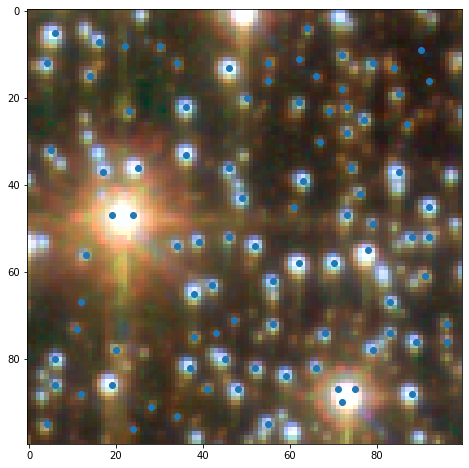

In [6]:
# closer inspection

plt.figure(figsize=(8,8))
plt.imshow(channels[1200:1300,1200:1300])

# find local maxima = stars
lm = peak_local_max(grey[1200:1300,1200:1300],min_distance=3)
# plot them
plt.scatter(lm[:,1],lm[:,0])

Now let's try to identify all the stars in the image and extrac their rgb-channel info.

In [7]:
stars = peak_local_max(grey,min_distance=3)

In [8]:
# how many stars did we find?
stars.shape

(140155, 2)

As one can see we found over 140'000 stars. Some of the larger stars may have been detected more than once and some of the dimmest may have been forgotten but this should be enough to get a rough idea about the structure of the cluster.

In [9]:
starRGB = channels[stars[:,0],stars[:,1],:]

Since there are quite a few stars we will only work with a smaller random subset. Also let's normalize the rgb values to the range of (0,1) since this is going to make visualisation with matplotlib more convenient.

In [10]:
N = 45000
select = np.random.choice(len(starRGB),size=N)

In [11]:
selectRGB = starRGB[select,:]/255.0

We can visualize the result as a 3d scatterplot below.

Text(0.5, 0, 'Blue Channel')

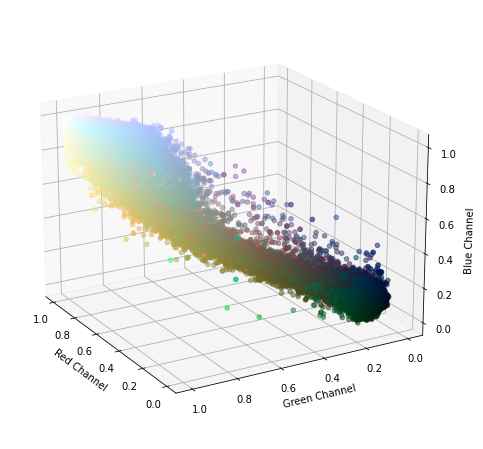

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(20,150)
ax.scatter(selectRGB[:,0],selectRGB[:,1],selectRGB[:,2],c=selectRGB,alpha=0.5)
ax.set_xlabel("Red Channel")
ax.set_ylabel("Green Channel")
ax.set_zlabel("Blue Channel")

The plot reveals an interesting distribution of the values. Allthough the feature space is 3-dimensional, the colour values seems to follow a curved one dimensional line. Hence it appears the star spectrum is more or less defined by one variable - which we hope to identify with the temperature later. However, it seems we have detected quite a few very dim stars where we cannot clearly identify a colour. These stars will be filtered out once we proceed.

In [13]:
normRGB = np.sqrt(np.sum(selectRGB**2,axis=1))
filterRGB = selectRGB[normRGB > 0.4]

Text(0.5, 0, 'Blue Channel')

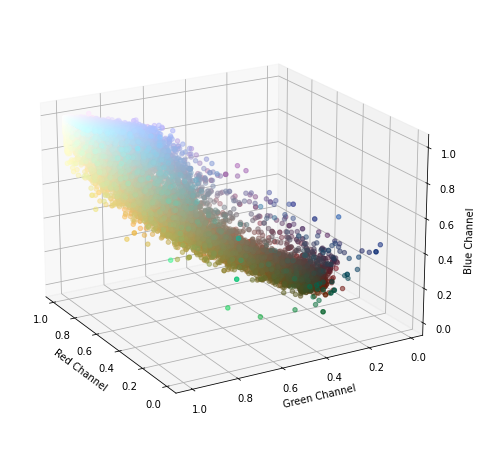

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(20,150)
ax.scatter(filterRGB[:,0],filterRGB[:,1],filterRGB[:,2],c=filterRGB,alpha=0.5)
ax.set_xlabel("Red Channel")
ax.set_ylabel("Green Channel")
ax.set_zlabel("Blue Channel")

From a theoretical perspective a black body spectrum in the frequency domain is characterized by plancks law.
$$ B(f) \propto \frac{f^3}{\exp{(h f / k T})-1} $$
Suppose we use a filter with band-with $\Delta f$ around some frequency $f_0$ to measure how high the intensity of the rediation in this part of the spectrum is. The intentsity would be approximately $B(f_0) \Delta f$, given $\Delta f$ is small. Hence we could approximate the rgb-channel values of the image by $(r,g,b) \propto (B(f_r,f_g,f_g))$ where the $f_i$ are the respective filter passing values. Note that we cannot really get absolute value here and hence we normalize all values to constant intensity.

In [15]:
def rgb_normalized(T,lam):
    """
        T: Temperature of star in Kelvin [n]
        lam: [n,3] array of wavelength in nm to evaluate at
    """
    hf = 6.626e-34*1e9*3e8/lam
    kT = 1.38e-23*T
    rgb = (hf**3)[None,:]/(np.exp(hf[None,:]/kT[:,None])-1.0)
    return rgb/np.sqrt(np.sum(rgb**2,axis=1))[:,None]

In [16]:
T = np.linspace(2000,20000,num=1000)
lam = np.asfarray([814,606,336])
tnorm_rgb = rgb_normalized(T,lam)


In [17]:
# normalize the star rgb
projRGB = filterRGB/normRGB[normRGB > 0.4,None]

One can now plot the normalized colour values, which lay on one 8th of the surface of the sphere and compare them with the theoretical curve created by the black body law and a varying temperature. As one can see they do not math perfectly but their shape is similar. Given we dont know the exact sensitvity of the filters use for the 3 different channels, it still seems like a good match.

Text(0.5, 0, 'Blue Channel')

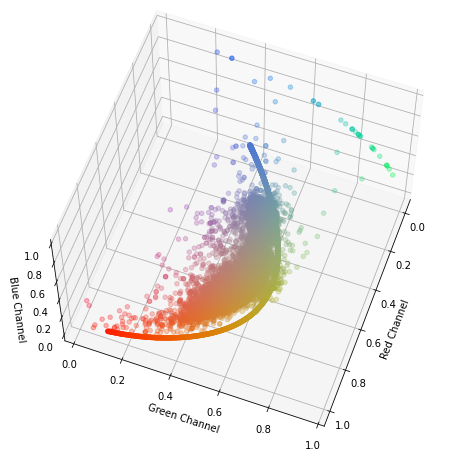

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(60,20)
ax.scatter(tnorm_rgb[:,0],tnorm_rgb[:,1],tnorm_rgb[:,2],c=tnorm_rgb,alpha=1.0)
ax.scatter(projRGB[:,0],projRGB[:,1],projRGB[:,2],c=projRGB,alpha=0.3)
ax.set_xlabel("Red Channel")
ax.set_ylabel("Green Channel")
ax.set_zlabel("Blue Channel")


Now we can try to estimate the temperature distribution in the star temperatures. By simply estimating it to be the closest match from the theoretical curve.

In [19]:
from scipy.spatial.distance import cdist

In [20]:
Tstar = T[np.argmin(cdist(tnorm_rgb,projRGB),axis=0)]

(array([3.200e+01, 6.000e+01, 8.800e+01, 2.020e+02, 2.060e+02, 2.470e+02,
        4.530e+02, 8.080e+02, 1.270e+03, 1.364e+03, 1.161e+03, 9.460e+02,
        7.770e+02, 7.740e+02, 2.638e+03, 1.691e+03, 1.068e+03, 4.020e+02,
        9.200e+01, 3.000e+01, 1.100e+01, 5.000e+00, 7.000e+00, 7.000e+00,
        1.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 0.000e+00, 2.100e+01]),
 array([ 2000.,  2600.,  3200.,  3800.,  4400.,  5000.,  5600.,  6200.,
         6800.,  7400.,  8000.,  8600.,  9200.,  9800., 10400., 11000.,
        11600., 12200., 12800., 13400., 14000., 14600., 15200., 15800.,
        16400., 17000., 17600., 18200., 18800., 19400., 20000.]),
 <BarContainer object of 30 artists>)

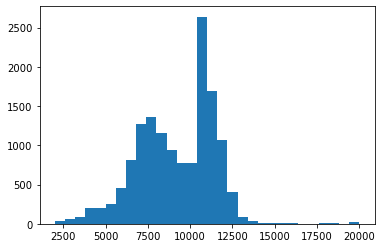

In [21]:
plt.hist(Tstar,bins=30)

(array([  29.,   62.,  155.,  347.,  826., 3233., 3284., 6182.,  214.,
          39.]),
 array([7.60090246, 7.83116097, 8.06141948, 8.29167799, 8.5219365 ,
        8.75219501, 8.98245352, 9.21271202, 9.44297053, 9.67322904,
        9.90348755]),
 <BarContainer object of 10 artists>)

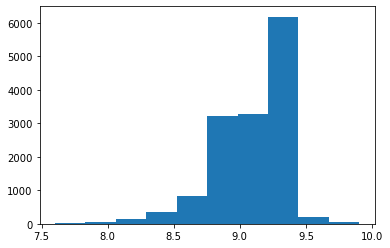

In [26]:
plt.hist(np.log(Tstar),bins=10)

In [29]:
np.log(3000)

8.006367567650246